The difference between pivot tables and GroupBy can sometimes cause confusion; it helps me to think of **pivot tables as essentially a multidimensional version of GroupBy aggregation**. That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

# Motivating Pivot Tables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic.shape

(891, 15)

# Pivot Tables by Hand

In [4]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


In [7]:
titanic.groupby(['sex', 'class'])['survived'].aggregate(['mean']).unstack()

mean                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

# Pivot Table Syntax

In [8]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## Multi-level pivot tables

In [9]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [11]:
age.head()

0    (18, 80]
1    (18, 80]
2    (18, 80]
3    (18, 80]
4    (18, 80]
Name: age, dtype: category
Categories (2, interval[int64]): [(0, 18] < (18, 80]]

## Additional pivot table options

In [12]:
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived': sum, 'fare': 'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

In [13]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


In [14]:
births = pd.read_csv('../data/births.csv')

In [15]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [17]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Text(0, 0.5, 'total births per year')

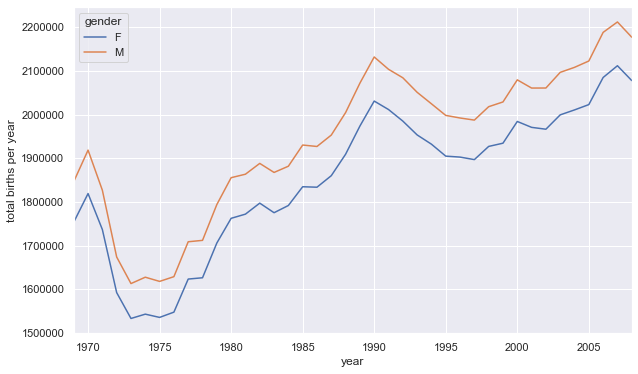

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()

births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot(figsize=(10, 6))
plt.ylabel('total births per year')

## Further data exploration

In [25]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

In [26]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

In [27]:
births['day'] = births['day'].astype(int)

In [28]:
births.index = pd.to_datetime(10000 * births.year 
                              + 100 * births.month 
                              + births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek

Text(0, 0.5, 'mean births by day')

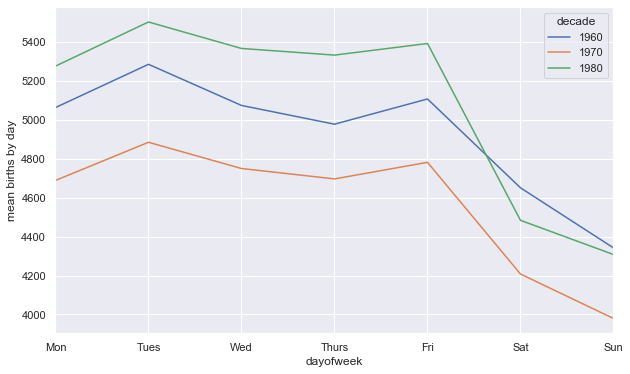

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot(figsize=(10, 6))
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

In [30]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [31]:
births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


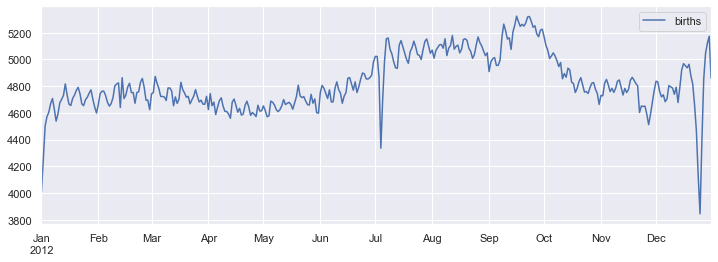

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)